# Run phylogenetic scan for mutations enriched in different hosts

This notebook will read in the analyses coded in `calculate-enrichment-scores` and `simulate-mutation-gain-loss-markov-chain` and run them. 

**Notes from testing November 21, 2022**
When I revisited this, I realized there were a whole bunch of issues with this scan, and that we weren't picking up signals I thought we should be. This lead me to think in more detail about what exactly we are trying to capture, and how we could alter this method to really work for us. 

Most GWAS methods are looking for something like disease presence/absence, where the presence of a mutation causes a disease or results in a host switch. While we would be interested in those sorts of interactions, we are also interested in mutations that are neutral in birds, but advantageous in humans. In fact, these types of mutations may be the ones we are most interested in. PB2 E627K is one such example, where it is well-tolerated in birds, but confers a large replication advantage in humans. For mutations like this, I think a reasonable underlying principle should be that it is enriched in humans (meaning, its frequency on human tips is higher than the overall frequency of human tips on the tree), while its frequency in birds is not higher than expected by chance. This can be evaluated with a Fisher's exact test, which compares a 2 x 2 contingency table. It turns out that the method we are using is exactly a Fishers test. The "enrichment score" is in fact just the odds ratio that is calculated in the Fishers exact test. However, one issue I was encountering was that I was getting really weird results: there were mutations with outrageously high scores that were only present on the tree 1 or 2 times. This isn't really the signal we want. So I wondered next whether we could compare the p-values instead. So, instead of just recording the odds ratio, also recording the p-value per mutation, and comparing the pvalues to the pvalues of simulated mutations. Intuitively this feels fine to me, although there is something odd about comparing pvalues to other pvalues. I also removed the minimum count requirement; I decided I might as well just post-filter. This minimum count was also skewing my simulated scores in an unexpected way: because in many trees the mutation never occurred, I was throwing out all of these 0 scores , when they should have been part of the distribution I'm comparing to. 

When I reran this test using pvalues and no minimum count, this improved our detection of known variants and of variants with positive DMS prefs. I think that this is because the pvalue comparison is automatically trying to account for mutations that have very low counts on the tree. Under this test, PB2 E627K is very significant, because its frequency is highly skewed towards humans. Meanwhile, PB2 N701D remains significant, but is more significant by odds ratio, because it is found in 3 humans and 0 birds. N701D is therefore highly skewed, with low counts, while 627K is medium skewed, but with high counts. It seems from my testing that comparing pvalues adds in this control for counts in a way that comparing odds ratios does not, so I am inclined to think it is a good way to go. 

What to do now: 
1. Plot our score subsetted by significant or not vs. DMS value. 
2. Ensure that we are mutating properly/enough
3. Figure out how many simulations to run to get reliable results 
4. Figure out a cutoff for our pvalues; top 5-10% seems maybe ok. 

In [1]:
import glob, json
import re,copy, imp
import pandas as pd 
import numpy as np
import time

import rpy2
%load_ext rpy2.ipython

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

In [2]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run calculate-enrichment-scores-across-tree-JSON.ipynb
%run simulate-mutation-gain-loss-markov-chain.ipynb

In [3]:
from datetime import date
current_date = str(date.today())

In [4]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

# Infer mutations on tree and calculate enrichment scores

There are 2 main choice here: the minimum required count, and the method. For every amino acid on the tree, the enrichment score will not be returned if it is present in less than `minimum required count` tips. I have arbitrarily set this to 5 currently, but it could be another number. For the method, there are 2: `proportions` and `counts`. In `counts`, we calculate an odds ratio as: `(A*D)/(B*C)`, where `A`,`B`,`C`, and `D` are counts of tips. In `proportions`, we calculate `(A+D)-(B+C)` where the cells are the proportion of total tips in each category. The `counts` method output is the exact odds ratio calculated with a Fisher's exact test. 

There are a few outputs: the `times_detected_dict` outputs the number of times that the mutation arose on the tree. The counts in `scores_dict` represent the number of tips with each mutation. 

To run this on amino acids, put in the gene name under `gene`. To run on nucleotide mutations, replace gene with `nuc`. 

In [5]:
#tree_path = "/Users/lmoncla/src/h5n1-host-classification/avian-flu-k99/old-and-test-subsamplings/auspice/flu_avian_h5n1_pb2.json"
#tree_path = "/Users/lmoncla/src/avian-flu/auspice/flu_avian_h5n1_pb2.json"
#tree_path = "/Users/lmoncla/src/h5n1-gwas/test-data/flu_avian_h5n1_ha.json"
#tree_path = "/Users/lmoncla/src/avian-flu-h5nx-subsampled-gwas/auspice/flu_avian_h5n1_ha.json"
tree_path = "/Users/lmoncla/src/avian-flu-h5nx-subsampled-gwas/auspice/flu_avian_h5n1_pb2.json"
#tree_path = "/Users/lmoncla/src/avian-flu/auspice/flu_avian_h5n1_ha.json"

#host_annotation = 'domestic_wild'
host_annotation = 'host'

gene = "PB2"
host1 = "Human"
host2 = "Avian"
minimum_required_count = 0
method = "counts"

In [6]:
tree = read_in_tree_json(tree_path)


Tree height: 51.182718
Tree length: 2707.529923
annotations present

Numbers of objects in tree: 4931 (2100 nodes and 2831 leaves)



In [7]:
nonzero_branches = 0
for k in tree.Objects:
    divergence = k.traits['node_attrs']['div']

    # if this happens at the root, set parent divergence to 0
    if k.parent.traits == {}:
        parent_div = 0
    else:
        parent_div = k.parent.traits['node_attrs']['div']
        
    branch_length = divergence - parent_div
    if branch_length > 0: 
        nonzero_branches += 1

print(nonzero_branches)

3336


In [8]:
aa_muts, nt_muts = gather_all_mut_on_tree(tree, gene)
print(len(aa_muts))
print(len(nt_muts))

2260
6912


In [9]:
total_host_tips_on_tree = return_all_host_tips(tree, host1, host2, host_annotation)
print(total_host_tips_on_tree)

total_tree_branch_length, tree_branch_lengths = return_total_tree_branch_length(tree)
print(total_tree_branch_length)

{'Human': 387, 'Avian': 2261, 'other': 183}
8.128676442083709


In [10]:
# calculate enrichment scores for all mutations along the tree
# must set method to be counts or proportions
# the host_counts variable in calculate_enrichmenet_scores is total_host_tips_on_tree
scores, scores_dict, times_detected_dict, branch_lengths_dict, host_counts_dict2 = calculate_enrichment_scores(tree, aa_muts, nt_muts, host1, host2, host_annotation, minimum_required_count, method, total_host_tips_on_tree)

In [11]:
pvalues = []
for s in scores_dict: 
    pvalue = scores_dict[s]['pvalue']
    pvalues.append(pvalue)


In [12]:
print(len(scores_dict))

2260


In [14]:
print(np.min(pvalues))
print(np.mean(pvalues))
print(np.median(pvalues))
print(np.max(pvalues))
print(np.percentile(pvalues,10))

2.6497157273982993e-110
0.43480046047788634
0.27088971612211865
1.0
1.5310086181992524e-06


In [15]:
print(np.min(scores))
print(np.mean(scores))
print(np.median(scores))
print(np.max(scores))
print(np.percentile(scores, 90))

0.0
11.475241129341974
2.154964583307307
103.88378378378378
47.72559366754617


In [20]:
for s in scores_dict:
    if "X" not in s:
        if scores_dict[s]['pvalue'] < np.percentile(pvalues, 5) and scores_dict[s]['enrichment_score'] > np.percentile(scores, 95):
            print(s, scores_dict[s]['enrichment_score'], scores_dict[s]['pvalue'])
        elif scores_dict[s]['pvalue'] < np.percentile(pvalues, 5):
            print("lowest 5% p-value: ", s,  scores_dict[s]['pvalue'])
        elif scores_dict[s]['enrichment_score'] > np.percentile(scores, 95):
            print("highest 5% by enrichment score: ", s,  scores_dict[s]['enrichment_score'])

lowest 5% p-value:  K526R 1.3228375371404002e-22
lowest 5% p-value:  A108V 8.52600707557746e-09
lowest 5% p-value:  M64I 8.176507235584077e-56
lowest 5% p-value:  I229V 5.958753300119431e-10
lowest 5% p-value:  I451V 4.649254906893421e-11
lowest 5% p-value:  V255L 8.297140763106675e-10
lowest 5% p-value:  S470N 3.205868263383323e-11
lowest 5% p-value:  N715S 2.107763420765592e-12
lowest 5% p-value:  E627K 2.2921753972031673e-29
lowest 5% p-value:  T524I 1.909567313586947e-51
lowest 5% p-value:  K339T 2.612135333718058e-27
lowest 5% p-value:  D680G 1.5255907108658308e-12
lowest 5% p-value:  R389K 1.23874649662315e-08
lowest 5% p-value:  R288Q 5.436477872247627e-75
lowest 5% p-value:  K80R 5.519428480029051e-11
lowest 5% p-value:  M473L 5.063962926072389e-14
lowest 5% p-value:  V480I 1.646121273043337e-08
lowest 5% p-value:  N102S 6.077436348701449e-09
lowest 5% p-value:  S465P 2.486391042065936e-10
lowest 5% p-value:  V495A 2.909015153606066e-08
lowest 5% p-value:  D195E 1.2900471457911

### Now do simulations

The `min_required_count_sims` should be the same number as the above `minimum_required_count`

The output for `sims_times_detected` will be the number of times in each iteration that the simulated mutation arose. This includes occurrences on internal nodes and on terminal nodes. 

Scores of 0 occur when the mutation was never detected/present in host 1. 

In [80]:
iterations = 1000
min_required_count_sims = 0

start_time = time.time()

sim_scores, sim_scores_dict, sim_times_detected, branches_that_mutated = perform_simulations(tree, gene, iterations, total_tree_branch_length, host1, host2, host_annotation, min_required_count_sims, method, total_host_tips_on_tree)

# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
total_time_hours = total_time_minutes/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes,", total_time_hours," hours) to generate", iterations, "simulated trees")

this took 1364.6081809997559 seconds ( 22.743469683329263  minutes, 0.3790578280554877  hours) to generate 1000 simulated trees


In [81]:
#sim_scores_dict
#sim_scores, sim_times_detected

In [82]:
# print number of scores that are greater than 0 
count = 0
for s in scores: 
    if s > 0: 
        count += 1
        
print(count, len(scores))

1364 2260


In [83]:
# print number of scores that are greater than 0 
count = 0
for s in sim_scores: 
    if s > 0: 
        count += 1
        
print(count, len(sim_scores))

194 1000


In [84]:
simulated_ORs = sim_scores

simulated_pvalues = []
for i in sim_scores_dict:
    pvalue = sim_scores_dict[i]["W1M"]["pvalue"]
    simulated_pvalues.append(pvalue)

In [85]:
print(np.min(simulated_ORs))
print(np.mean(simulated_ORs))
print(np.median(simulated_ORs))
print(np.max(simulated_ORs))
print(np.percentile(simulated_ORs, 0.025), np.percentile(simulated_pvalues, 97.5))
print(type(simulated_ORs))

0.0
1.6111229253746038
0.0
66.43076923076923
0.0 1.0
<class 'list'>


In [86]:
print(np.min(simulated_pvalues))
print(np.mean(simulated_pvalues))
print(np.median(simulated_pvalues))
print(np.max(simulated_pvalues))
print(np.percentile(simulated_pvalues, 0.025), np.percentile(simulated_pvalues, 97.5))
print(type(simulated_pvalues))

7.1824380513508e-96
0.7715066945224222
1.0
1.0
8.590877503074085e-96 1.0
<class 'list'>


In [87]:
percentile_95_pvalues = np.percentile(simulated_pvalues, 5)
percentile_99_pvalues = np.percentile(simulated_pvalues, 1)
percentile_999_pvalues = np.percentile(simulated_pvalues, 0.1)
percentile_9999_pvalues = np.percentile(simulated_pvalues, 0.01)

print(percentile_95_pvalues, percentile_99_pvalues, percentile_999_pvalues, percentile_9999_pvalues)

1.4540835697029258e-11 1.248882758165049e-70 1.281619585824394e-95 7.745813832040115e-96


In [88]:
percentile_95_ORs = np.percentile(simulated_ORs, 95)
percentile_99_ORs = np.percentile(simulated_ORs, 99)
percentile_999_ORs = np.percentile(simulated_ORs, 99.9)
percentile_9999_ORs = np.percentile(simulated_ORs, 99.99)

print(percentile_95_ORs, percentile_99_ORs, percentile_999_ORs, percentile_9999_ORs)

6.601515151515101 40.45823155837812 65.96259668446976 66.38395197613926


In [89]:
PB2_muts = ["E627K", "I292T", "D701N"]
for m in PB2_muts:
    print(m, scores_dict[m], host_counts_dict2[m], times_detected_dict[m])


#print(scores_dict["G1906A"], host_counts_dict2['G1906A'])
#print(scores_dict['A150V'], host_counts_dict2['A150V'])

E627K {'enrichment_score': 4.052464978448276, 'pvalue': 2.2921753972031673e-29} {'Human': 155, 'Avian': 320, 'other': 11} 55
I292T {'enrichment_score': 6.198028156503975, 'pvalue': 8.929453905531817e-40} {'Human': 134, 'Avian': 178, 'other': 7} 17
D701N {'enrichment_score': 103.88378378378378, 'pvalue': 7.237816153450704e-14} {'Human': 17, 'Avian': 0, 'other': 2} 15


In [90]:
# test for significance using pvalues 
print(len(scores_dict))
high_scores = {}
significant = 0

for s in scores_dict:
    
    """for this, we are printing based on having a p-value lower than the bottom 5% of simulated p-values,
    with a postive enrichment score, where the mutation is not an X (due to missing data), and it occurred/arose
    on the tree > 1 time"""
    if scores_dict[s]["pvalue"] < np.percentile(simulated_pvalues, 5) and scores_dict[s]["enrichment_score"] > 1:
        if s[-1] != "X" and s[-1] != "-"and times_detected_dict[s]>1:
            print(s, scores_dict[s], times_detected_dict[s], host_counts_dict2[s])
            significant += 1
            high_scores[s] = [scores_dict[s]]
        
print(significant)

2260
K526R {'enrichment_score': 3.8542925252261373, 'pvalue': 1.3228375371404002e-22} 12 {'Human': 116, 'Avian': 226, 'other': 8}
M64I {'enrichment_score': 7.52056712132089, 'pvalue': 8.176507235584077e-56} 2 {'Human': 331, 'Avian': 995, 'other': 78}
E627K {'enrichment_score': 4.052464978448276, 'pvalue': 2.2921753972031673e-29} 55 {'Human': 155, 'Avian': 320, 'other': 11}
T524I {'enrichment_score': 11.378903413217138, 'pvalue': 1.909567313586947e-51} 6 {'Human': 115, 'Avian': 81, 'other': 6}
R340K {'enrichment_score': 23.289879931389365, 'pvalue': 6.01352910080829e-76} 12 {'Human': 372, 'Avian': 1166, 'other': 104}
P465S {'enrichment_score': 57.920731707317074, 'pvalue': 2.9315515579412328e-43} 5 {'Human': 59, 'Avian': 7, 'other': 1}
T105A {'enrichment_score': 4.055461711711712, 'pvalue': 2.213520329940144e-15} 10 {'Human': 67, 'Avian': 111, 'other': 5}
D701N {'enrichment_score': 103.88378378378378, 'pvalue': 7.237816153450704e-14} 15 {'Human': 17, 'Avian': 0, 'other': 2}
T339K {'enri

In [63]:
"""correct for multiple testing"""
significance_threshold = 0.05#/len(scores_dict)

# for odds ratios comparisons, calculate a percentile of significance since we want the highest scores
percentile_of_significance = 100-(significance_threshold*100)

# for pvalues, we want the lowest scorese, so can just use the significance threshold 
#percentile_of_significance = significance_threshold
percentile_of_significance = significance_threshold*100

significant_score = np.percentile(simulated_pvalues,percentile_of_significance)

print(significance_threshold, percentile_of_significance, significant_score)

0.05 5.0 1.4401605379420203e-11


In [64]:
print(len(scores_dict))
high_scores = {}
significant = 0

for s in scores_dict:
    if scores_dict[s]['pvalue'] < np.percentile(simulated_pvalues, percentile_of_significance):
    #if scores_dict[s] > np.max(simulated):
    #if scores_dict[s] > np.percentile(simulated, 95):
        if s[-1] != "X" and s[-1] != "-" and times_detected_dict[s]>1 and host_counts_dict2[s]['Human']>1:
            print(s, scores_dict[s], times_detected_dict[s], host_counts_dict2[s])
            significant += 1
            high_scores[s] = [scores_dict[s]]
        
print(significant)

2260
K526R {'enrichment_score': 3.8542925252261373, 'pvalue': 1.3228375371404002e-22} 12 {'Human': 116, 'Avian': 226, 'other': 8}
M64I {'enrichment_score': 7.52056712132089, 'pvalue': 8.176507235584077e-56} 2 {'Human': 331, 'Avian': 995, 'other': 78}
E627K {'enrichment_score': 4.052464978448276, 'pvalue': 2.2921753972031673e-29} 55 {'Human': 155, 'Avian': 320, 'other': 11}
T524I {'enrichment_score': 11.378903413217138, 'pvalue': 1.909567313586947e-51} 6 {'Human': 115, 'Avian': 81, 'other': 6}
M473L {'enrichment_score': 0.288611520510931, 'pvalue': 5.063962926072389e-14} 3 {'Human': 33, 'Avian': 552, 'other': 57}
R340K {'enrichment_score': 23.289879931389365, 'pvalue': 6.01352910080829e-76} 12 {'Human': 372, 'Avian': 1166, 'other': 104}
P465S {'enrichment_score': 57.920731707317074, 'pvalue': 2.9315515579412328e-43} 5 {'Human': 59, 'Avian': 7, 'other': 1}
T105A {'enrichment_score': 4.055461711711712, 'pvalue': 2.213520329940144e-15} 10 {'Human': 67, 'Avian': 111, 'other': 5}
D701N {'enr

In [65]:
sim_scores_pvalues_df = pd.DataFrame(simulated_pvalues, columns = ["pvalue"])
sim_scores_pvalues_df.head()

,pvalue
0,1.000000e+00
1,1.000000e+00
2,1.404935e-62
3,3.749517e-01
4,1.000000e+00


In [66]:
sim_scores_ORs_df = pd.DataFrame(simulated_ORs, columns = ["score"])
sim_scores_ORs_df.head()

,score
0,0.000000
1,0.000000
2,0.045134
3,0.000000
4,0.000000


In [67]:
actual_scores_df = pd.DataFrame()
for m in scores_dict: 
    enrichment_score = scores_dict[m]["enrichment_score"]
    pvalue = scores_dict[m]["pvalue"]
    local_df = pd.DataFrame({"mutation":[m], "score":[enrichment_score],"pvalue":[pvalue]})
    actual_scores_df = actual_scores_df.append(local_df)
print(len(actual_scores_df))
actual_scores_df.head()

2260


,mutation,score,pvalue
0,M202V,0.000000,1.000000e+00
0,I292V,0.346012,1.749364e-03
0,P104X,59.973475,3.834737e-08
0,L259W,11.745455,5.769313e-02
0,I398M,0.000000,1.000000e+00


In [68]:
significant_score = percentile_95_pvalues
print(significant_score)

1.4401605379420203e-11


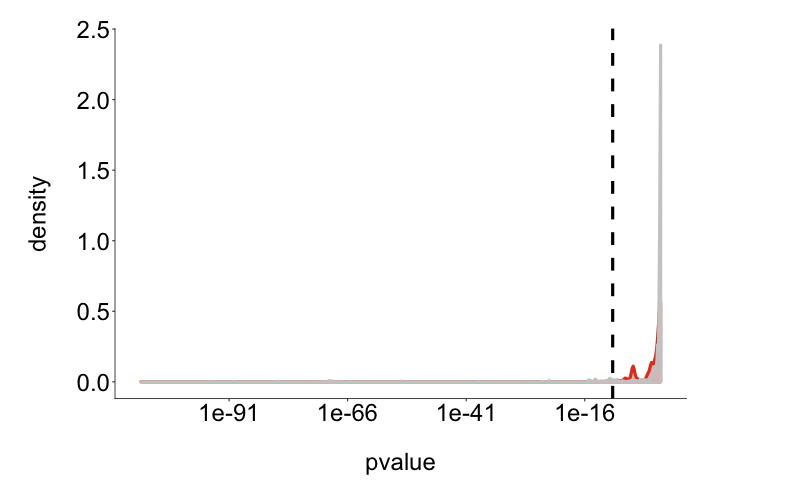

In [56]:
%%R -w 800 -h 500 -u px -i actual_scores_df,sim_scores_pvalues_df,significant_score,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("PB2-gwas-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_density(data=actual_scores_df, aes(x=pvalue), alpha=0.4, size=1.5, color=human_color, fill=human_color)+
    geom_density(data=sim_scores_pvalues_df, aes(x=pvalue), alpha=0.4, size=1.5, color="grey80", fill="grey80")+
    geom_vline(aes(xintercept=significant_score), linetype="dashed", size=1.5, color="black")+
    labs(x="\npvalue", y="density\n")+
#     scale_color_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=domestic_color,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=human_color), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_fill_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=NA,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=NA), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_linetype_manual(values=c(wild_to_domestic_data="solid",wild_to_domestic_shuffled_dates="dashed",domestic_to_human_data="solid", domestic_to_human_shuffled_dates="dashed"), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    #scale_y_continuous(breaks=seq(0,0.3,0.05), limits=c(0,0.3))+
    scale_x_log10()+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+  
    theme(strip.text.x=element_text(size=24))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", hjust=0.5))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.text=element_text(size=30))+
    theme(legend.title=element_blank())

    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 9, height = 6, device = "pdf", path = "../figures", dpi = 300)
p

In [57]:
significant_score = percentile_95_ORs

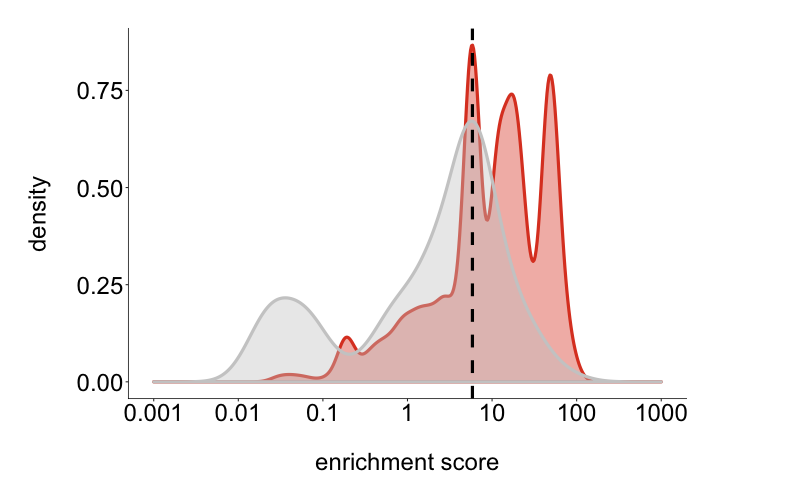

In [63]:
%%R -w 800 -h 500 -u px -i actual_scores_df,sim_scores_ORs_df,significant_score,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("PB2-gwas-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_density(data=actual_scores_df, aes(x=score), alpha=0.4, size=1.5, color=human_color, fill=human_color)+
    geom_density(data=sim_scores_ORs_df, aes(x=score), alpha=0.4, size=1.5, color="grey80", fill="grey80")+
    geom_vline(aes(xintercept=significant_score), linetype="dashed", size=1.5, color="black")+
    labs(x="\nenrichment score", y="density\n")+
#     scale_color_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=domestic_color,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=human_color), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_fill_manual(values=c(wild_to_domestic_data=domestic_color,wild_to_domestic_shuffled_dates=NA,domestic_to_human_data=human_color, domestic_to_human_shuffled_dates=NA), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
#     scale_linetype_manual(values=c(wild_to_domestic_data="solid",wild_to_domestic_shuffled_dates="dashed",domestic_to_human_data="solid", domestic_to_human_shuffled_dates="dashed"), labels=c(wild_to_domestic_data="wild to domestic (data)",wild_to_domestic_shuffled_dates="wild to domestic (shuffled dates)",domestic_to_human_data="domestic to human (data)", domestic_to_human_shuffled_dates="domestic to human (shuffled dates)"))+
    #scale_x_continuous(breaks=seq(0,100,25), limits=c(-10,100))+
    scale_x_log10(limits=c(0.001,1000), breaks=c(0.001,0.01,0.1,1,10,100,1000), labels=c("0.001","0.01","0.1","1","10","100","1000"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+  
    theme(strip.text.x=element_text(size=24))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(size=24, colour="black", hjust=0.5))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.text=element_text(size=30))+
    theme(legend.title=element_blank())

    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 9, height = 6, device = "pdf", path = "../figures", dpi = 300)
p

## Plot mutations vs. branch length 

This is just to check to make sure that the number of times a branch mutates in the simulations is proportional to its branch length. 

In [102]:
# branches that mutated is output from the simulations and represents the total number of times a branch was mutated
# during the course of the simulations; it is a dictionary that starts at 0 and adds a count each time the simulation
# is run
df1 = pd.DataFrame.from_dict(branches_that_mutated, orient="index")
df1.reset_index(inplace=True)
df1.head()

,index,branch_length,times_mutated
0,NODE_0000286,0.048631,4
1,A/Environment/Chongqing/99165/2014,0.005272,1
2,NODE_0000544,0.045166,6
3,NODE_0002310,0.007384,1
4,NODE_0000564,0.010022,2


From playing with this a little bit, when we run 100 simulations, we get mutations on about 100 branches. If we run 1000, we get mutations on ~500 branches. Ideally, we would want to simulate such that we capture getting a mutation on most non-zero branch length branches in the tree. This number is 1195. So we need to do a lot more simulations if we'd like to capture getting a mutation on most branches. When I ran 10,000 sims, we mutated 1071 branches, which is pretty close. 

In [103]:
# print the minimum and maximum times a branch mutated, along with the unique branches that did mutate 
# there are 1328 objects in the tree
print(min(df1["times_mutated"]), max(df1["times_mutated"]))
print(len(set(df1['index'].tolist())))

1 13
732


In [104]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

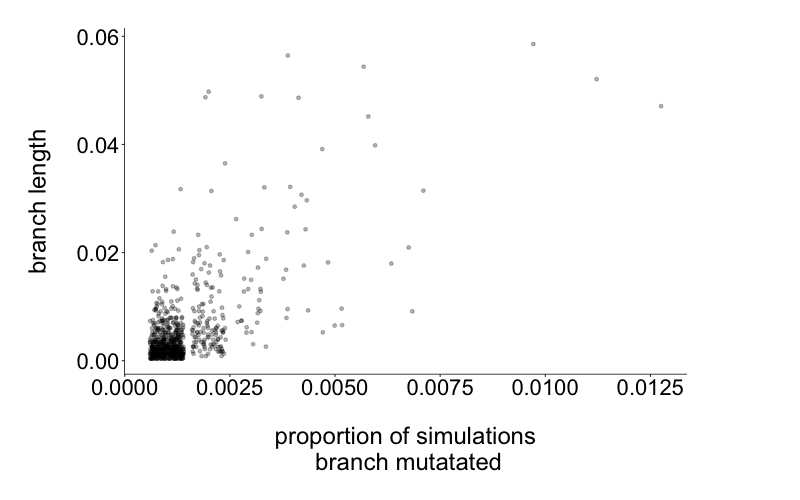

In [105]:
%%R -w 800 -h 500 -u px -i df1,iterations,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("muts-vs-bl-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=df1, aes(x=times_mutated/iterations, y=branch_length), color="black",alpha=0.3)+
    #geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    #geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    labs(x="\nproportion of simulations\n branch mutatated",y="branch length\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 7, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

## Compare the distribution of times a site mutates in the simulation to the actual data 

In theory, we should be capturing a similar mean distribution of the number of times a site will mutate in our simulation vs. our data. I'd like to see if that is true. 

In [36]:
# convert to dataframe and transpose
times_detected_df = pd.DataFrame([times_detected_dict]).T
times_detected_df.reset_index(inplace=True)
times_detected_df.columns = ["mutation","times_detected"]
times_detected_df['source'] = "data"
times_detected_df.head()

,mutation,times_detected,source
0,T224I,2,data
1,A397T,1,data
2,I319T,1,data
3,A44S,1,data
4,I356V,1,data


In [37]:
# PB2 has 759 amino acids in it 
all_muts = set(times_detected_df['mutation'].tolist())
all_sites = []

for a in all_muts: 
    site = a[1:-1]
    all_sites.append(site)
    
all_sites = set(all_sites)
print(len(all_sites))

479


In [38]:
# so, 280 sites never mutated; we need to add that to the dataframe 
non_mutated_df = pd.DataFrame(index=np.arange(759-479), columns=np.arange(3))
non_mutated_df.columns = ["mutation","times_detected","source"]
non_mutated_df['mutation'] = "A"
non_mutated_df['times_detected'] = 0
non_mutated_df['source'] = 'data'
non_mutated_df.head()

,mutation,times_detected,source
0,A,0,data
1,A,0,data
2,A,0,data
3,A,0,data
4,A,0,data


In [39]:
# convert to dataframe and transpose
sim_times_detected_df = pd.DataFrame(sim_times_detected).T
sim_times_detected_df.reset_index(inplace=True)
sim_times_detected_df["source"] = "simulated"
sim_times_detected_df.columns = ["mutation","times_detected","source"]
sim_times_detected_df.head()

,mutation,times_detected,source
0,0,1,simulated
1,1,2,simulated
2,2,1,simulated
3,3,1,simulated
4,4,0,simulated


In [40]:
# combine
combined_times_detected_df = times_detected_df.append(sim_times_detected_df).append(non_mutated_df)
combined_times_detected_df.head()

,mutation,times_detected,source
0,T224I,2,data
1,A397T,1,data
2,I319T,1,data
3,A44S,1,data
4,I356V,1,data


In [41]:
# convert to proportions 
x = pd.DataFrame(times_detected_df.append(non_mutated_df)['times_detected'].value_counts())
x.reset_index(inplace=True)
x.columns = ['times_detected_on_tree','number_of_mutations']
x['source'] = 'data'
x['proportion_of_mutations'] = x['number_of_mutations']/len(times_detected_df)
x.head()

,times_detected_on_tree,number_of_mutations,source,proportion_of_mutations
0,1,507,data,0.605735
1,0,280,data,0.334528
2,2,154,data,0.183990
3,3,59,data,0.070490
4,4,35,data,0.041816


In [42]:
%%R -w 800 -h 500 -u px -i combined_times_detected_df,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("times-mutated-data-vs-sims-",current_date,".pdf", sep="")

# adding in the y = stat(count / sum(count)) will make the y-axis be proportions instead of counts

p <- ggplot() + 
    geom_histogram(data=combined_times_detected_df, aes(x=times_detected, y = stat(count / sum(count), color=source, fill=source), position="dodge", binwidth=1, size=0.2)+
    labs(x="\nnumber of times site mutated",y="proportion of sites\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(0.5, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
p


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:34:1: unexpected symbol
33: #ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
34: p
    ^


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:34:1: unexpected symbol
33: #ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "../figures", dpi = 300)
34: p
    ^

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: `panel.margin` is deprecated. Please use `panel.spacing` property instead 

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncl

## Thoughts 

I am not mutating as much as the actual data. So in my simulations, I am getting more sites with 0 mutations and fewer sites with 1 mutation than is in my actual data. 

# Compare to DMS values

A reasonable comparison should be to see whether any of these PB2 mutations scored well in [Shirleen's PB2 DMS paper.](https://elifesciences.org/articles/45079). I'd like to see whether the mutations I find as significant have generally negative or positive DMS values. 

In [80]:
def return_times_detected_mut(mutation, times_detected_dict):
    if mutation in times_detected_dict: 
        times_detected = times_detected_dict[mutation]
    else:
        times_detected = 0
        
    return(times_detected)

In [81]:
def read_in_dms_preferences(dms_file):
    
    mut_prefs = {}
    
    with open(dms_file, "r") as infile: 
        for line in infile: 
            site = line.split(",")[0]
            wt = line.split(",")[1]
            mut = line.split(",")[2]
            mut_diff_sel = line.split(",")[11]

            full_mut = wt + site + mut
            mut_prefs[full_mut] = mut_diff_sel

    return(mut_prefs)

In [82]:
def return_dms_pref(mutation, mut_prefs):
    if mutation in mut_prefs:
        preference = mut_prefs[mutation]
    else:
        #print(mutation)
        preference = None
    
    return(preference)

In [83]:
def read_in_previously_identified(known_muts_file):
    
    known_muts = {}
    
    with open(known_muts_file, "r") as infile: 
        for line in infile: 
            site = line.split("\t")[0]
            full_mut = line.split("\t")[1]
            source = line.split("\t")[2]
            verified = line.split("\t")[3]
            strain = line.split("\t")[6].strip()

            known_muts[full_mut] = {"source":source, "verified":verified, "strain":strain}
    
    return(known_muts)

In [84]:
def return_known_muts(mutation, known_muts):
    if mutation in known_muts: 
        annotation = "known"
    else:
        annotation = "not"
        
    return(annotation)

In [85]:
def return_known_muts_method(mutation, known_muts):
    if mutation in known_muts: 
        annotation = known_muts[mutation]['source'] + "_" + known_muts[mutation]['verified']
    else:
        annotation = "not"
        
    return(annotation)

In [86]:
def return_labels(mutation, muts_to_label_list):
    if mutation in muts_to_label_list:
        label = str(mutation)
    else:
        label = ""
    return(label)

In [87]:
dms_file = "../data/summary_prefs_effects_diffsel.csv"
known_muts_file = "../data/Soh-elife-previously-validated-muts.tsv"

dms_prefs = read_in_dms_preferences(dms_file)
known_muts = read_in_previously_identified(known_muts_file)

In [88]:
DMS_list = [9,82,163,176,182,183,292,355,521,522,532,534,627,669,701,112,378,382]
muts_to_label = ["E627K","D701N","K526R","I292T"]

In [89]:
actual_scores_df['significant'] = np.where(actual_scores_df['mutation'].isin(high_scores), "significant", "not")

In [90]:
#actual_scores_df['significant'] = np.where(actual_scores_df['score'] > significant_score, "significant", "not")
actual_scores_df['times_detected'] = actual_scores_df['mutation'].apply(return_times_detected_mut,args=[times_detected_dict])
actual_scores_df['DMS_prefs'] = actual_scores_df['mutation'].apply(return_dms_pref, args=[dms_prefs])
actual_scores_df['known'] = actual_scores_df['mutation'].apply(return_known_muts, args=[known_muts])
actual_scores_df['known_how'] = actual_scores_df['mutation'].apply(return_known_muts_method, args=[known_muts])
actual_scores_df['label'] = actual_scores_df['mutation'].apply(return_labels, args=[muts_to_label])


#actual_scores_df = actual_scores_df.melt(id_vars=['mutation',"score"])
actual_scores_df.head()

,mutation,score,pvalue,significant,times_detected,DMS_prefs,known,known_how,label
0,M458L,0.000000,1.000000e+00,not,1,0.09159421160419803,not,not,
0,A44X,78.556150,1.417035e-10,not,14,None,not,not,
0,Q13X,3.627642,6.710487e-05,not,49,None,not,not,
0,L349F,0.000000,1.000000e+00,not,1,-0.06632125091062209,not,not,
0,Q75X,59.973475,3.834737e-08,not,10,None,not,not,


In [91]:
actual_scores_df['DMS_prefs'] = pd.to_numeric(actual_scores_df['DMS_prefs'])
actual_scores_df.head()

,mutation,score,pvalue,significant,times_detected,DMS_prefs,known,known_how,label
0,M458L,0.000000,1.000000e+00,not,1,0.091594,not,not,
0,A44X,78.556150,1.417035e-10,not,14,NaN,not,not,
0,Q13X,3.627642,6.710487e-05,not,49,NaN,not,not,
0,L349F,0.000000,1.000000e+00,not,1,-0.066321,not,not,
0,Q75X,59.973475,3.834737e-08,not,10,NaN,not,not,


In [92]:
actual_scores_df[actual_scores_df['mutation']=="E627K"]

,mutation,score,pvalue,significant,times_detected,DMS_prefs,known,known_how,label
0,E627K,4.052465,2.292175e-29,significant,55,0.546131,known,Exptevol_Yes,E627K


In [93]:
sloth = actual_scores_df[actual_scores_df['significant'] == "significant"]
#sloth = actual_scores_df[actual_scores_df['known'] == "known"]

sloth

,mutation,score,pvalue,significant,times_detected,DMS_prefs,known,known_how,label
0,Q288R,6.446791,5.584631e-07,significant,3,-0.189510,not,not,
0,Q591R,9.851658,2.488667e-03,significant,4,-0.656025,known,Natural_No,
0,I260V,5.482934,1.458344e-04,significant,8,2.133250,not,not,
0,T292A,35.590551,5.782331e-05,significant,2,NaN,not,not,
0,S489P,7.385471,4.932575e-03,significant,6,2.041974,known,Natural_Yes,
0,T106A,3.250981,1.221571e-06,significant,19,0.185803,not,not,
0,K340R,7.666667,1.227009e-04,significant,7,NaN,not,not,
0,T81A,4.954424,3.973902e-05,significant,10,-0.817794,not,not,
0,K197R,2.426013,1.063995e-04,significant,7,-0.546062,not,not,
0,I463V,2.806475,5.954738e-07,significant,14,-0.150682,not,not,


In [94]:
percentile_95

5.857512953367876

In [95]:
actual_scores_df[actual_scores_df['mutation']=="E627K"]

,mutation,score,pvalue,significant,times_detected,DMS_prefs,known,known_how,label
0,E627K,4.052465,2.292175e-29,significant,55,0.546131,known,Exptevol_Yes,E627K


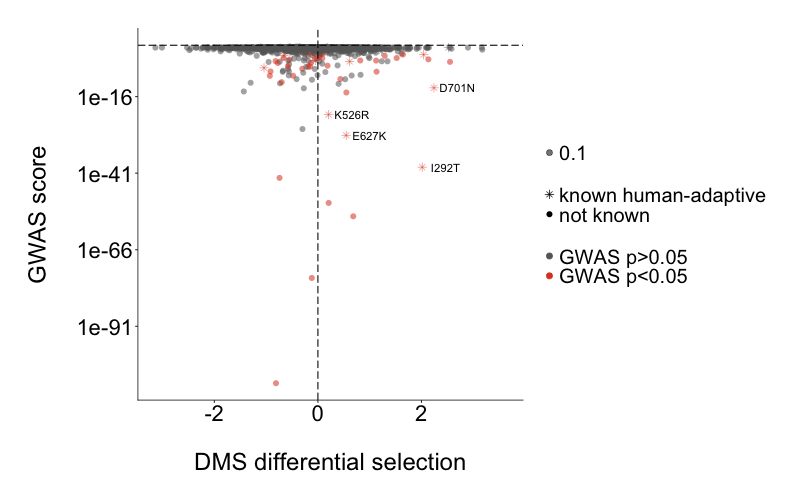

In [100]:
%%R -w 800 -h 500 -u px -i actual_scores_df,percentile_95,percentile_99,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

actual_scores_df$DMS_prefs = as.numeric(actual_scores_df$DMS_prefs)
output_filename = paste("pb2-scores-vs-dms-prefs2-human-domestic-OR-",current_date,".pdf", sep="")

p <- ggplot(data=actual_scores_df, aes(y=pvalue, x=DMS_prefs, shape=known)) + 
    #geom_violin()+
    geom_jitter(aes(color=significant, alpha=0.1), size=2.5)+
    geom_hline(aes(yintercept=percentile_95), linetype=5)+
    geom_vline(aes(xintercept=0), linetype=5)+
    geom_label(data=actual_scores_df, aes(x=DMS_prefs+0.45,y=pvalue, label=label),label.size=NA, size=4, fill=NA)+
    labs(x="\nDMS differential selection",y="GWAS score\n")+
    scale_color_manual(values=c(not="grey40",significant=human_color), labels=c(not="GWAS p>0.05", significant="GWAS p<0.05"))+
    scale_shape_manual(values=c(known=8,not=16), labels=c(known="known human-adaptive", not="not known"))+
    scale_y_log10()+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

#ggsave(output_filename, width = 10, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

In [222]:
x = actual_scores_df[actual_scores_df['times_detected'] > 1]
true_pos = len(actual_scores_df[(actual_scores_df['score'] > percentile_95) & (actual_scores_df['DMS_prefs'] > 0)])
false_pos = len(actual_scores_df[(actual_scores_df['score'] > percentile_95) & (actual_scores_df['DMS_prefs'] < 0)])
true_neg = len(actual_scores_df[(actual_scores_df['score'] < percentile_95) & (actual_scores_df['DMS_prefs'] < 0)])
false_neg = len(actual_scores_df[(actual_scores_df['score'] < percentile_95) & (actual_scores_df['DMS_prefs'] > 0)])
print(true_pos, false_pos, true_neg, false_neg)

22 31 184 135


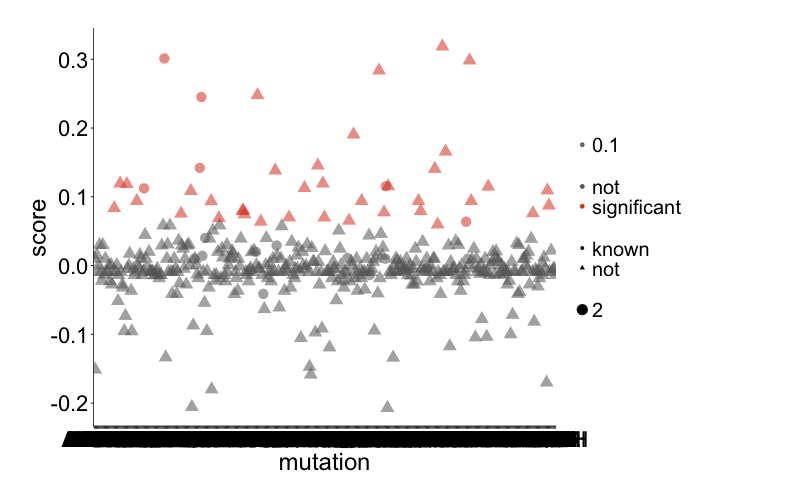

In [170]:
%%R -w 800 -h 500 -u px -i actual_scores_df,percentile_95,percentile_99,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("pb2-scores-dots-",current_date,".pdf", sep="")

p <- ggplot(data=actual_scores_df, aes(x=mutation, y=score, color=significant, shape=DMS)) + 
    #geom_violin()+
    geom_jitter(aes(color=significant, alpha=0.1, size=2))+
#     geom_hline(aes(yintercept=percentile_95), linetype=5)+
#     geom_hline(aes(yintercept=percentile_99), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    #labs(x="",y="circulation time (years)\n")+
     scale_color_manual(values=c(not="grey40",significant=human_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

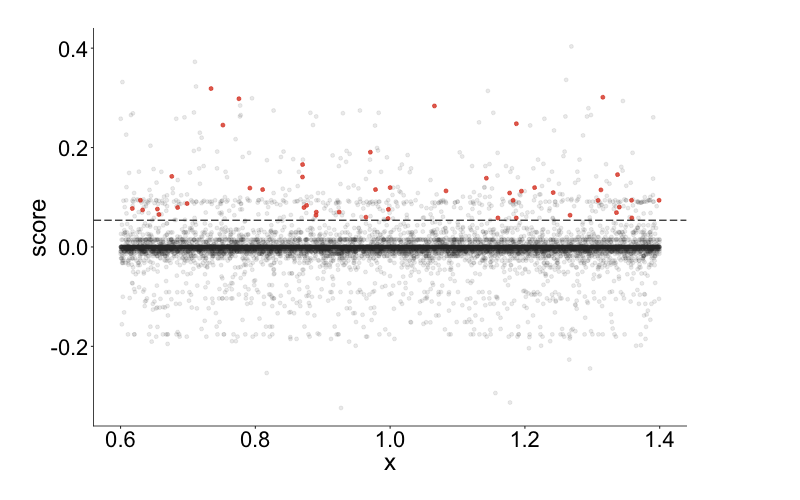

In [292]:
%%R -w 800 -h 500 -u px -i sim_scores_df,high_scores_df,percentile_95,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("pb2-scores-dots-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=sim_scores_df, aes(x=1, y=score), color="grey20",alpha=0.1)+
    geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    #labs(x="",y="circulation time (years)\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
#     scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
#     scale_x_continuous(breaks=seq(0,1,0.2), limits=c(-0.05,1.0))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 6, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

## Plot a tree with branches colored by number of times they mutated in my simulation

In [263]:
df1 = pd.DataFrame.from_dict(branches_that_mutated, orient="index")
df1.reset_index(inplace=True)
df1.head()

,index,branch_length,times_mutated
0,A/Americanwigeon/Washington/196340/2015,0.001298,1
1,A/Cambodia/V0219301/2011,0.002572,1
2,A/Cambodia/W0526301/2012,0.002586,1
3,A/Chicken/Henan/210/2004,0.039149,1
4,A/Chicken/Turkey-Isparta/09rs2841-37/2006,0.004334,1


In [264]:
print(min(df1["times_mutated"]), max(df1["times_mutated"]))
print(len(set(df1['index'].tolist())))

1 3
101


In [265]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

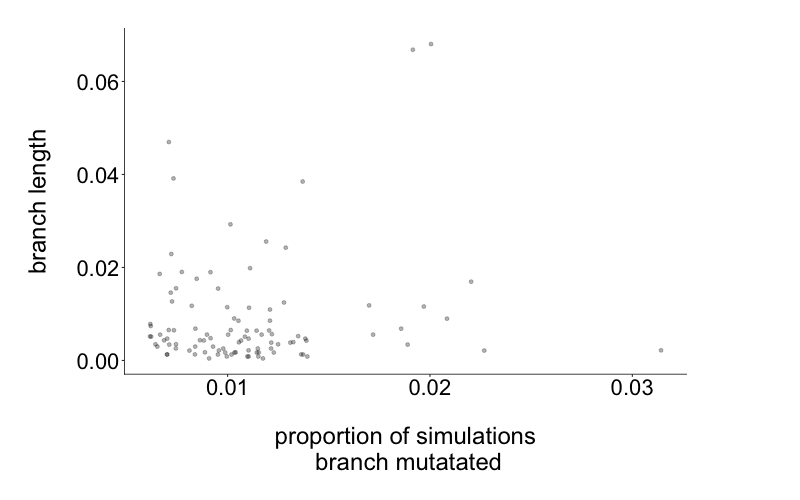

In [267]:
%%R -w 800 -h 500 -u px -i df1,iterations,current_date,human_color,domestic_color,wild_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("muts-vs-bl-",current_date,".pdf", sep="")

p <- ggplot() + 
    geom_jitter(data=df1, aes(x=times_mutated/iterations, y=branch_length), color="black",alpha=0.3)+
    #geom_jitter(data=high_scores_df, aes(x=1, y=score), color=human_color, alpha=0.8)+
    #geom_hline(aes(yintercept=percentile_95), linetype=5)+
    #geom_label(data=high_scores_df, aes(x=score,y=7500, label=mutation),label.size=NA, size=2)+
    labs(x="\nproportion of simulations\n branch mutatated",y="branch length\n")+
    #scale_color_manual(values=c(human=human_color,wild=wild_color,domestic=domestic_color))+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    #scale_x_continuous(breaks=seq(0,50,10), limits=c(0,50))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 7, height = 5, device = "pdf", path = "../figures", dpi = 300)
p

In [145]:
def plot_tree(width, length, tree, filename, muts_dict, maximum):
    
    fig,ax = plt.subplots(figsize=(width,length),facecolor='w')

    colors = clr.LinearSegmentedColormap.from_list('custom ', [wild_color, domestic_color], N=maximum)

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    min_date = 1975
    dates_ls = []
    for i in np.arange(min_date,2020,5):
        dates_ls.append(i) 
    [ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates_ls]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::2]:
    #     date_labels.append(dates_dict[d]['label'])
    #     if d < 2020:
    #         date_labels.append("")

    branchWidth=1.25 ## default branch width
    tipSize = 15

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        #print(muts_dict[k], (muts_dict[k])/maximum, colors(((muts_dict[k])/maximum)))
       
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
            
        if muts_dict[k] == 0:
            c = "black"
#         elif muts_dict[k] > 10:
#             c = "blue"
#         else:
#             c = "green"
            
        if k.parent not in muts_dict:
            parent_color = "black"
#         elif muts_dict[k.parent] == 0:
#             parent_color = "black"
#         elif muts_dict[k.parent] > 10:
#             parent_color = "blue"
#         else:
#             parent_color = "green"

        if k.branchType=='leaf': ## if leaf...        
            #c=colors((muts_dict[k])/maximum)
            s=tipSize
            #parent_color = colors((muts_dict[k.parent])/maximum)
            a=1

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        elif k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025

            # if we are not at the root
            if k.parent.traits != {}:
                #c=colors((muts_dict[k])/maximum)
                a=1
                #parent_color = colors((muts_dict[k.parent])/maximum)
            else:
                print("root")
                c="black"
                a=1
                parent_color = c

            # this is the vertical line connecting nodes; 
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)
            ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)

        # add in a legend
        han_list = []

    # put in color bar
    # these coordinates are right, bottom, width, length
    ax3 = fig.add_axes([0.0, 0.30, 0.05, 0.25])   
    mpl.colorbar.ColorbarBase(ax3, cmap=colors)
    ax3.tick_params(size=2,labelsize=18)
    ax3.set_title('number times mutated', size=18)
    
    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-5,tree.ySpan+5)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    #ax.set_xlim(1970,2020)
    ax.set_xlim(min_date,2020)
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.1, 0.2], loc=3,prop={'size': 16}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)

    plt.savefig(filename)

    plt.show()

root


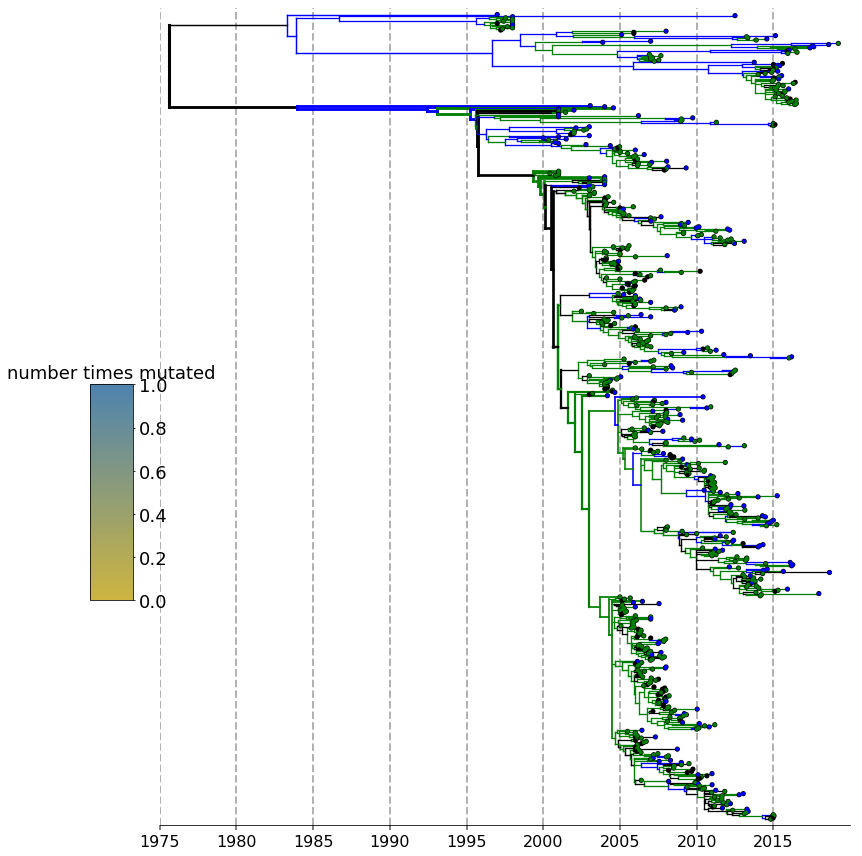

In [146]:
filename = "PB2-tree-by-sim-muts.pdf"
width = 12
length = 12
maximum = 181

plot_tree(width, length, tree, filename, muts_by_bl_dict, maximum)

In [714]:
from collections import defaultdict

In [717]:
slothattack = defaultdict(int)
slothattack[9] += 1

In [718]:
print(slothattack)

defaultdict(<class 'int'>, {9: 1})
